# Absolute vs relative performance estimation

Absolute performance estimation is labour intensive as we need many samples to get decent performance.
Hence, it is hard to estimate performance improvements when changes are small, i.e., you do model maintenance.
Then there is clever trick to compare relative performance of different models. 
This measures the difference between model performance measures an is much more precise than the difference of absolute errors provided that we have large number of unlabelled data.
On flip side, it requires manual evaluation of unseen data samples and thus cannot be automated. 


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from keras.optimizers import Adam
from plotnine import *

from model_library.display_code import display_source
from model_library.dataframe_manipulation import combine_two_dataframes

In [2]:
import sys
sys.path.append('../../image-generation/')

## I. Data generation

Relative performance estimation requires lots of unlabelled data what si not part of [MNIST dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset). To bypass this issue, we use an image generator that was trained on MNIST dataset.
This does not simulate new numbers perfectly but it allows to see how estimation techniques work.


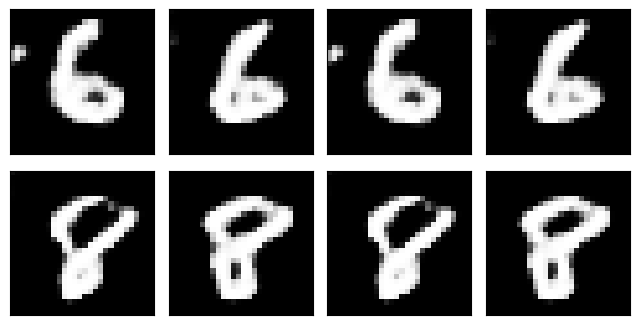

In [3]:
from keras.saving import load_model as load_keras_model
from image_generators.conditional_gan import generate_samples
from image_generators.conditional_gan.default_components import config

generator = load_keras_model('../../image-generation/models/mnist_gan_generator.keras') 

sixes = generate_samples(generator, config, label=6, sample_count=4, verbose=0)
eights = generate_samples(generator, config, label=8, sample_count=4, verbose=0)

fig, axs = plt.subplots(2, 4, figsize=(8, 4))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.setp(axs, xticks=[], yticks=[], xlabel='', ylabel='', aspect='equal')
axs[0, 0].imshow(sixes[0], cmap='gray', vmin=0, vmax=1)
axs[0, 1].imshow(sixes[1], cmap='gray', vmin=0, vmax=1)
axs[0, 2].imshow(sixes[0], cmap='gray', vmin=0, vmax=1)
axs[0, 3].imshow(sixes[1], cmap='gray', vmin=0, vmax=1)
axs[1, 0].imshow(eights[0], cmap='gray', vmin=0, vmax=1)
axs[1, 1].imshow(eights[1], cmap='gray', vmin=0, vmax=1)
axs[1, 2].imshow(eights[0], cmap='gray', vmin=0, vmax=1)
axs[1, 3].imshow(eights[1], cmap='gray', vmin=0, vmax=1)
plt.show()

For conveniance, we use a helper function that allows us to generate $2n$ samples with equal proportions for both classes.  

In [4]:
from model_library.data_loaders import generate_image_pairs
display_source(generate_image_pairs)

```python
def generate_image_pairs(n: int, generator: keras.Model, config,
                         class_0: int, class_1: int, verbose: int = 0) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Generates n samples of digits for both classes separately, i.e., the outcome contains 2 * n samples.
    Final labels will be zero and one instead of original class labels defined as arguments.
    """
    images = tf.reshape(tf.stack([
        generate_samples(generator, config, label=class_0, sample_count=n, verbose=verbose),
        generate_samples(generator, config, label=class_1, sample_count=n, verbose=verbose)
    ], axis=1), (-1, 28, 28))
    labels = tf.tile(tf.constant([0, 1], 'int32'), (n,))

    return images, labels

```

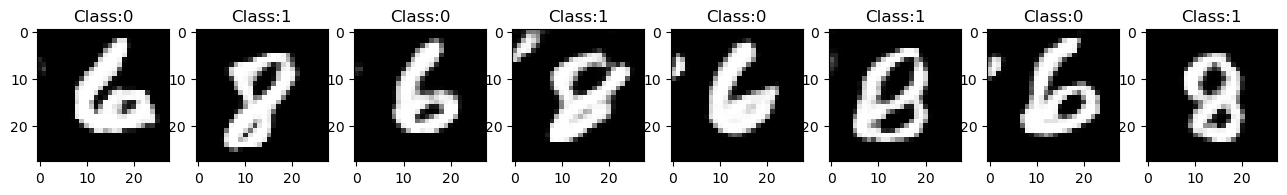

In [5]:
images, labels = generate_image_pairs(4, generator, config, 6, 8)
fig, axs = plt.subplots(1, 8, figsize=(16, 4))
for i in range(0, 8): 
    axs[i].imshow(images[i], cmap='gray', vmin=0, vmax=1)
    axs[i].set_title(f'Class:{labels[i]}')

## II. Model training

From the previous notebook [01_scaling_laws_on_minst_data.ipynb](./01_scaling_laws_on_minst_data.ipynb) we know that logistic regression models perform roughly the same when trained on 50 or 75 image pairs. Let us train two such models and compare their performance on generated images.  

In [6]:
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

training_data = dict()
n_max = min(min(sum(train_labels == 6), sum(train_labels == 8)), 5850)
training_data['6'] = tf.random.shuffle(train_images[train_labels == 6]/255.0)[:n_max]
training_data['8'] = tf.random.shuffle(train_images[train_labels == 8]/255.0)[:n_max]
assert(len(training_data['6']) == len(training_data['8']))

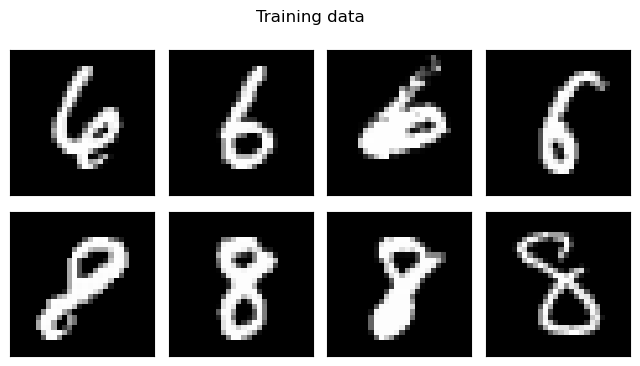

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
plt.suptitle('Training data')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.setp(axs, xticks=[], yticks=[], xlabel='', ylabel='', aspect='equal')
for i in range(4):
    axs[0, i].imshow(training_data['6'][i], cmap='gray', vmin=0, vmax=1)
    axs[1, i].imshow(training_data['8'][i], cmap='gray', vmin=0, vmax=1)
plt.show()

In [8]:
from model_library.logreg import mnist_logreg_model
logreg = mnist_logreg_model()
logreg.summary()
adam_lr = Adam(learning_rate=1e-3)
logreg.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])

Model: "Logistic_regression"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           785 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785 (3.07 KB)

 Trainable params: 785 (3.07 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from model_library.data_loaders import get_image_pairs
from model_library.model_training import train_binary_classifier

N = 50
model_1 = mnist_logreg_model()
adam_lr = Adam(learning_rate=1e-3)
model_1.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])
images, labels = get_image_pairs(N, training_data, '6', '8')
model_1, _ = train_binary_classifier(model_1, images, labels , epochs=10, batch_size=32, collect_telemetry=False)

N = 75
model_2 = mnist_logreg_model()
adam_lr = Adam(learning_rate=1e-3)
model_2.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])
images, labels = get_image_pairs(N, training_data, '6', '8')
model_2, _ = train_binary_classifier(model_2, images, labels , epochs=10, batch_size=32, collect_telemetry=False)

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

## III. Absolute performance evaluation

Next we are going to evaluate model performances on 1000 image pairs which a relatively decent testset size. 
Labelled test sets that are several orders bigger are quite rare  -- why would you waste precious data for testing.  

In [13]:
K = 20
N = 1000
telemetry = (pd.DataFrame(list(range(K)), columns=['experiment'])
             .set_index('experiment')
             .assign(model_1=np.nan, model_2=np.nan))

for i in tqdm(range(len(telemetry))):
    test_images, test_labels = generate_image_pairs(N, generator, config, 6, 8)
    telemetry.loc[i, 'model_1'] = model_1.evaluate(test_images, test_labels, verbose=0)[1] 
    telemetry.loc[i, 'model_2'] = model_2.evaluate(test_images, test_labels, verbose=0)[1] 

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/swen/Library/miniforge3/envs/huggingface/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 3 rows containing missing values.


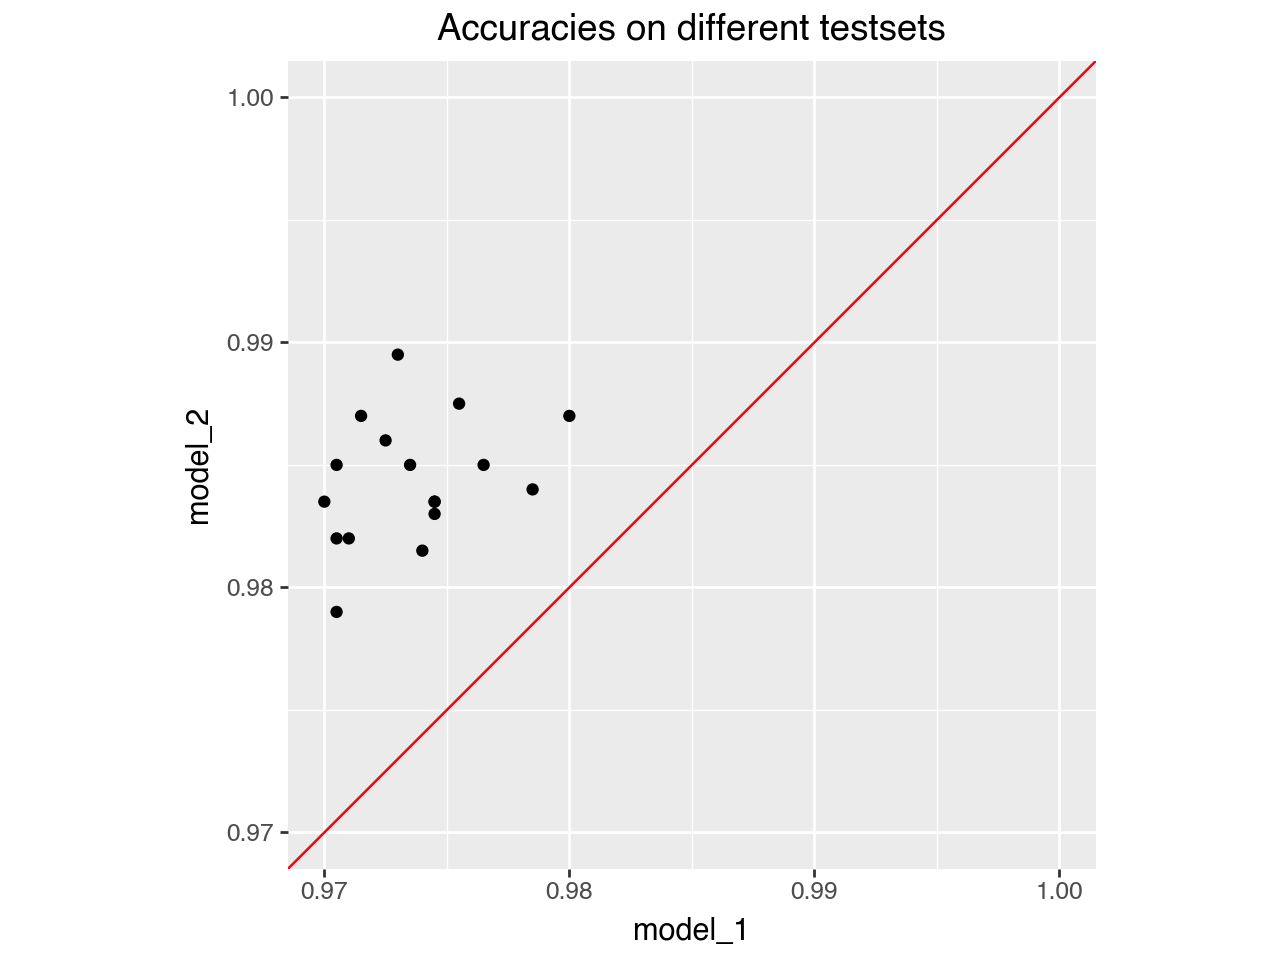

In [14]:
p  = ggplot(telemetry) 
p += geom_point(aes(x='model_1', y='model_2')) 
p += coord_fixed(ratio=1) 
p += xlim([0.97, 1.00]) 
p += ylim([0.97, 1.00])
p
p += geom_abline(intercept=0, slope=1, color='red')
p += ggtitle('Accuracies on different testsets')
p

## III. Relative performance evaluation

Relative performance evaluation assumes the existence of a large unlabelled test set which will be later on lazily labelled -- we label only these instances that matter. In this presentation, we use true labels for convenience, as manual labelling takes time.   

**1. Evaluate both models on unlabelled testset**

In [15]:
N = 100000
test_images, test_labels = generate_image_pairs(N, generator, config, 6, 8, verbose=1)

predictions_1 = tf.squeeze(model_1.predict(test_images) >= 0.5)
predictions_2 = tf.squeeze(model_2.predict(test_images) >= 0.5)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 103s 33ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 105s 34ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 266us/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 260us/step


**2. Estimate maximal accuracy difference between models** 

In [16]:
p_d = tf.reduce_mean(tf.cast(predictions_1 != predictions_2, 'float')).numpy()
print(f'Models differ on {p_d * 100:.2f}% samples in the unlabelled test set')

Models differ on 2.73% samples in the unlabelled test set


**3. Label a random sample of the difference set** 

In [17]:
dif_index = tf.squeeze(tf.where(predictions_1 != predictions_2))
dif_images = tf.gather(test_images, dif_index)
dif_predictions_1 = tf.gather(predictions_1, dif_index)
dif_predictions_2 = tf.gather(predictions_2, dif_index)

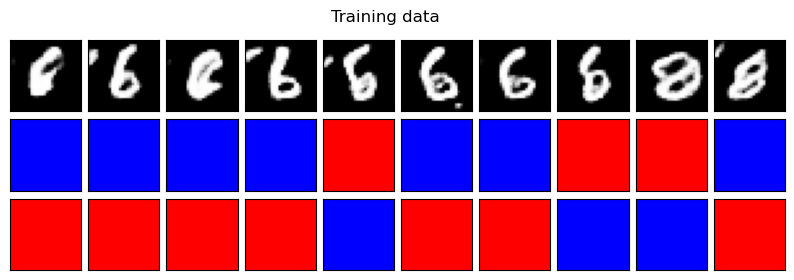

In [18]:
fig, axs = plt.subplots(3, 10, figsize=(10, 3))
plt.suptitle('Training data')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.setp(axs, xticks=[], yticks=[], xlabel='', ylabel='', aspect='equal')
for i in range(10):
    axs[0, i].imshow(dif_images[i], cmap='gray', vmin=0, vmax=1)
    axs[1, i].set_facecolor('blue' if dif_predictions_1[i].numpy() else 'red')
    axs[2, i].set_facecolor('blue' if dif_predictions_2[i].numpy() else 'red')


Let use corrrect labels to see which model is correct on a sample of size $1000$.

In [19]:
N = 1000

# Perform manual labbeling of both models 
dif_true_labels = tf.cast(tf.gather(test_labels, dif_index), 'bool')
model_1_correct = tf.reduce_sum(tf.cast(dif_predictions_1[:1000] == dif_true_labels[:1000], 'int32')).numpy()
model_2_correct = tf.reduce_sum(tf.cast(dif_predictions_2[:1000] == dif_true_labels[:1000], 'int32')).numpy()

relative_difference = (model_2_correct - model_1_correct)/N
print(f'Model 1 is correct {model_1_correct} and model 2 is correct {model_2_correct} number of cases.')
print(f'Model 2 is {relative_difference * 100:2.1f} percent points better on difference set.')

Model 1 is correct 313 and model 2 is correct 687 number of cases.
Model 2 is 37.4 percent points better on difference set.


**4. Compute the relative difference on the entire testset**

In [20]:
performance_difference = p_d * relative_difference
print(f'Model 2 is {performance_difference*100:2.3f} percent points better on the entire test set')

Model 2 is 1.020 percent points better on the entire test set


## IV. Theoretical treatment of relative performance evaluation

### A. Difference in risk can be stated in terms of prediction differences

Let $f_1$ and $f_2$ be classifiers which we want to compare and let $R$ be the risk (performance measure) which can be expressed as an expected loss over a random data point

\begin{align*}
R(f)=\mathbf{E}(L(y, f(\boldsymbol{x})))\enspace.
\end{align*}

Then the empirical risk (an estimate of performance measure) is an average

\begin{align*}
R_N(f)=\frac{1}{N}\cdot \sum_{i=1}^{N} L(y_i, f(\boldsymbol{x}_i)))\enspace.
\end{align*}

Consequently, we can estimate risk difference

\begin{align*}
\Delta R = R(f_1)-R(f_2)
\end{align*}

through the differences of empirical risks


\begin{align*}
\Delta R_N = \frac{1}{N}\cdot \sum_{i=1}^{N} L(y_i, f_1(\boldsymbol{x}_i))-L(y_i, f_2(\boldsymbol{x}_i))\enspace.
\end{align*}

Now it is evident that when $f_1(\boldsymbol{x}_i) = f_2(\boldsymbol{x}_i)$ then corresponding losses are the same and thus we need labels $y_i$ only for the set of differences 

\begin{align*}
\mathcal{I_\Delta}=\{ i: f_1(\boldsymbol{x}_i)\neq f(\boldsymbol{x}_i)\}\enspace.
\end{align*}

In particular note that


\begin{align*}
\Delta R_N = \frac{1}{N}\cdot \sum_{i\in \mathcal{I_\Delta}} L(y_i, f_1(\boldsymbol{x}_i))-L(y_i, f_2(\boldsymbol{x}_i))= \frac{|\mathcal{I}_\Delta|}{N}\cdot\frac{1}{|\mathcal{I}_\Delta|}\cdot \sum_{i\in \mathcal{I_\Delta}} L(y_i, f_1(\boldsymbol{x}_i))-L(y_i, f_2(\boldsymbol{x}_i))\enspace.
\end{align*}


### B. Performance on the set of differences can be approximated better

Let us now define the performance on the set of differences

\begin{align*}
\Delta R_{\mathcal{I}_\Delta} = \frac{1}{|\mathcal{I}_\delta|}\cdot \sum_{i\in \mathcal{I_\Delta}} L(y_i, f_1(\boldsymbol{x}_i)))-L(y_i, f_2(\boldsymbol{x}_i)))\enspace.
\end{align*}

and its relative size

\begin{align*}
\hat{p}_\Delta=\frac{|\mathcal{I}_\Delta|}{N}
\end{align*}

Then the empirical risk difference can be expressed as

\begin{align*}
\Delta R_N= \hat{p}_\Delta\cdot \Delta R_{\mathcal{I}_\Delta}.
\end{align*}

which implies

\begin{align*}
|\Delta R_N| \leq \hat{p}_\Delta\cdot \max |L(y, f(\boldsymbol{x}))- L(y, f_2(\boldsymbol{x}))|.
\end{align*}


By labelling a small random subset $\mathcal{I}$ of differences $\mathcal{I}_\Delta$ we can estimate  $\Delta R_{\mathcal{I}_\Delta}$ without looking through the entire set of differences:

\begin{align*}
\widehat{\Delta R}_{\mathcal{I}_\Delta} \approx \frac{1}{|\mathcal{I}|}\cdot \sum_{i\in \mathcal{I}} L(y_i, f_1(\boldsymbol{x}_i)))-L(y_i, f_2(\boldsymbol{x}_i)))\enspace.
\end{align*}


### C. Variance estimation through moment matching


Note that $\Delta R_{\mathcal{I_\Delta}}$ is population average whereas $\widehat{\Delta R}_{\mathcal{I_\Delta}}$ is sample average and thus we can use standard techniques for estimating their difference. 

However, note that the true risk difference $\Delta R$ also has the similar decomposition as the difference between empirical risks 

\begin{align*}
\Delta R = \mathbf{E}(L(y, f_1(\boldsymbol{x})-L(y, f_2(\boldsymbol{x})))) = \Pr[f_1(\boldsymbol{x})\neq f_2(\boldsymbol{x})]\cdot\mathbf{E}(L(y, f_1(\boldsymbol{x})-L(y, f_2(\boldsymbol{x})))| f_1(\boldsymbol{x})\neq f_2(\boldsymbol{x})) 
\end{align*}

In particular note that due to the central limit therem 

\begin{align*}
\hat{p}_\Delta&\to \Pr[f_1(\boldsymbol{x})\neq f_2(\boldsymbol{x})]=:p_\Delta\\
\widehat{\Delta R}_{\mathcal{I_\Delta}} &\to \mathbf{E}(L(y, f_1(\boldsymbol{x})-L(y, f_2(\boldsymbol{x})))| f_1(\boldsymbol{x})\neq f_2(\boldsymbol{x}))
\end{align*}

and we can use moment matching to estimate convergence

\begin{align*}
\mathbf{Var}(\hat{p}_\Delta)&\approx \frac{\hat{p}_\Delta(1-\hat{p}_\Delta)}{N}\\
\mathbf{Var}(\widehat{\Delta R}_{\mathcal{I_\Delta}})&\approx \frac{EmpVar}{|\mathcal{I}|} 
\end{align*}

where $EmpVar$ is the empirical variance of terms $L(y_i, f(\boldsymbol{x_i}))- L(y_i, f_2(\boldsymbol{x_i}))$ for $i\in \mathcal{I}$.
Note that the variance still proportional to $\frac{1}{|\mathcal{I}|}$ 
However, the rescaling factor $p_\Delta$ increases absolute precision when $p_\Delta$ is small -- the difference between the new and the old model is small.
